# Imports

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import phonecalls as pc
import asanisi as an
import copy
import os


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']

# Getting Data

In [2]:
%time mit_calls = pc.allcalls('CallLog.csv', (), 'participantID.A', 'number.hash', ['local_time'], "%Y-%m-%d %H:%M:%S", header=True, min_activity=1)
mit_calls.head()

CPU times: user 398 ms, sys: 56.5 ms, total: 454 ms
Wall time: 454 ms


,ego,alter,time,uclock,aclock
0,fa10-01-19,10153fa58c24d1a2eb54b3c6ac39482acb61131c,2010-12-31 16:44:24,307,0
1,fa10-01-22,101b96d65031e2792acd950125d90cf9ff30b5ac,2011-05-23 20:59:05,450,0
2,fa10-01-12,1023b616632f3ba048b2f1d1374788bfa0444a8d,2011-01-22 14:01:07,328,0
3,fa10-01-01,102c517fc9ecf84975448470893c3799f5588c8a,2011-05-27 17:52:56,454,0
4,fa10-01-07,102cd812edb5689302bcc57df8330cff44727bd1,2011-04-04 10:02:50,400,0


In [3]:
%time mit_pairs = pc.pairs(mit_calls)
mit_pairs.head()

CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 35.3 ms


,ego,alter,nij,k,n
0,fa10-01-01,102c517fc9ecf84975448470893c3799f5588c8a,1,516,3339
1,fa10-01-01,abac98a7f6c000a6600c0e9cc370b059a874c3fd,1,516,3339
2,fa10-01-01,b8bc40aefbb724dfbacb3fd296cbb10b2dd35a85,6,516,3339
3,fa10-01-01,b8b0f0fc34d4201df3ebb5ebcefbbb61a3499941,1,516,3339
4,fa10-01-01,b8af4e561030e5a28b441467ede33b9450dd8518,1,516,3339


In [4]:
%time mit_lives = pc.lives_dictionary(mit_calls)
# just to show how an entry looks like
mit_lives['fa10-01-01']['102c517fc9ecf84975448470893c3799f5588c8a']

CPU times: user 146 ms, sys: 6.62 ms, total: 152 ms
Wall time: 152 ms


{'t0': 454, 'tf': 454, 'nij': 1, 'ell': 0}

In [5]:
%time mit_calls = pc.remove_alters(mit_calls, mit_lives, 210) # only keep alters and phone calls appeared after 7 months, counting from the start of the data
mit_calls.head()

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['uclock'] -= num_days


CPU times: user 2.11 s, sys: 35.6 ms, total: 2.14 s
Wall time: 2.14 s


,ego,alter,time,uclock,aclock
0,fa10-01-19,10153fa58c24d1a2eb54b3c6ac39482acb61131c,2010-12-31 16:44:24,97,0
1,fa10-01-22,101b96d65031e2792acd950125d90cf9ff30b5ac,2011-05-23 20:59:05,240,0
2,fa10-01-12,1023b616632f3ba048b2f1d1374788bfa0444a8d,2011-01-22 14:01:07,118,0
3,fa10-01-01,102c517fc9ecf84975448470893c3799f5588c8a,2011-05-27 17:52:56,244,0
4,fa10-01-07,102cd812edb5689302bcc57df8330cff44727bd1,2011-04-04 10:02:50,190,0


In [6]:
%time mit_pairs = pc.pairs(mit_calls)
%time mit_lives = pc.lives_dictionary(mit_calls)

CPU times: user 29.8 ms, sys: 0 ns, total: 29.8 ms
Wall time: 28.6 ms
CPU times: user 109 ms, sys: 3.24 ms, total: 113 ms
Wall time: 113 ms


# Get $F$

This is a required step to obtain $b$

In [7]:
%time fall = pc.get_f(mit_calls, 'all', 180, 60)

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


CPU times: user 21.4 s, sys: 35 ms, total: 21.4 s
Wall time: 21.4 s


# From $F$ to $b$

In [8]:
%time blamb = pc.get_b(fall, 'lambda')
%time blambplot = pc.plot_g(blamb, 'lambda')

CPU times: user 2.52 s, sys: 23.7 ms, total: 2.54 s
Wall time: 2.54 s
CPU times: user 18.9 ms, sys: 166 µs, total: 19.1 ms
Wall time: 18.4 ms


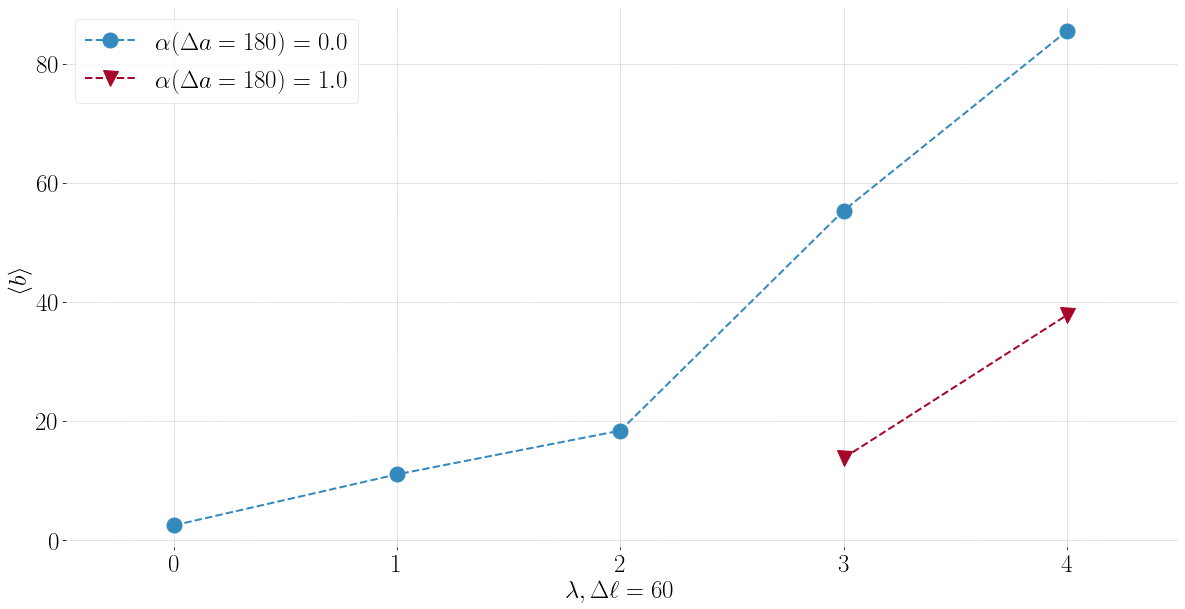

In [9]:
plt.xlabel(r"$\lambda, \Delta \ell = 60$")
plt.ylabel(r"$\langle b \rangle$")
plt.xlim(-0.5, 4.5)
plt.xticks(range(5))
for a in blambplot.keys():
    plt.plot(blambplot[a].index, blambplot[a]['lambda'], marker=markers[int(a)], markersize=15, linestyle="--", label=fr"$\alpha(\Delta a  = 180) = {a}$")
plt.legend()

In [10]:
%time fall2 = pc.get_f(mit_calls, 'all', 60, 180)
%time bal = pc.get_b(fall2, 'alpha')
%time balplot = pc.plot_g(bal, 'alpha')

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


CPU times: user 21.4 s, sys: 40 ms, total: 21.4 s
Wall time: 21.4 s
CPU times: user 2.66 s, sys: 16.8 ms, total: 2.67 s
Wall time: 2.68 s
CPU times: user 21.2 ms, sys: 50 µs, total: 21.3 ms
Wall time: 21.2 ms


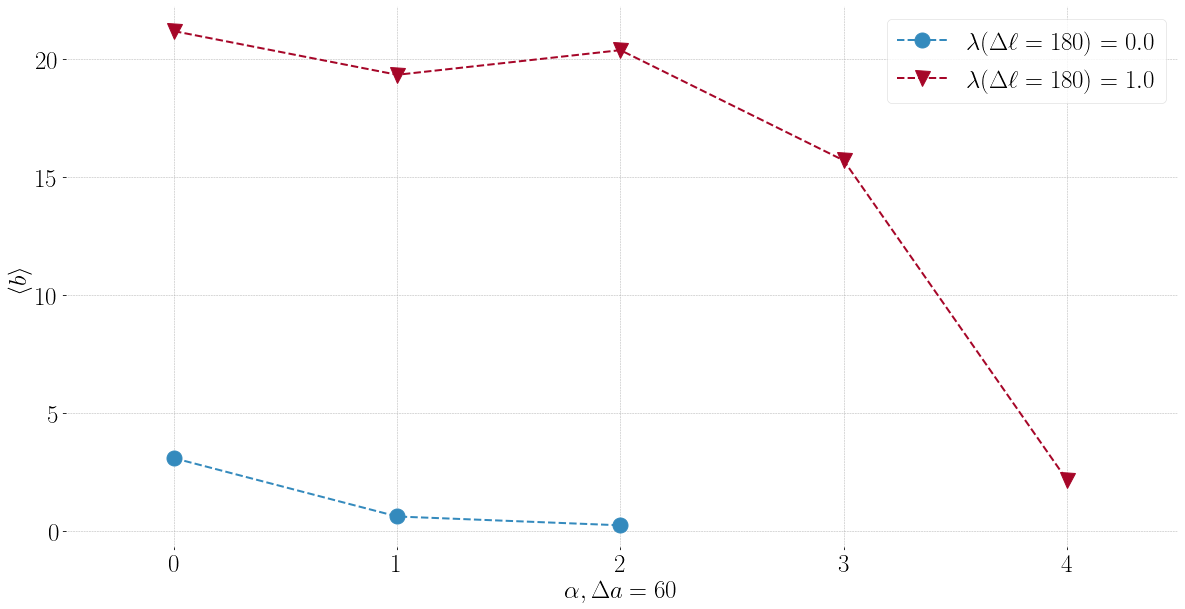

In [11]:
plt.xlabel(r"$\alpha, \Delta a = 60$")
plt.ylabel(r"$\langle b \rangle$")
plt.xlim(-0.5, 4.5)
plt.xticks(range(5))
for a in balplot.keys():
    plt.plot(balplot[a].index, balplot[a]['alpha'], marker=markers[int(a)], markersize=15, linestyle="--", label=fr"$\lambda(\Delta \ell  = 180) = {a}$")
plt.legend()

# Distributions of lifetime separated by $b$

Separated by activity. I will do this as a test using only $b$; but the idea is that evetually I'll use $F$

In [12]:
egolist = list(mit_calls['ego'].unique())

In [13]:
pd.set_option('mode.chained_assignment', None)

In [14]:
%time fall = pc.get_f(mit_calls, 'all', 60, 7)

CPU times: user 21 s, sys: 30.3 ms, total: 21 s
Wall time: 21 s


In [15]:
%time blamb = pc.get_b(fall, 'lambda')

CPU times: user 4.1 s, sys: 3.37 ms, total: 4.1 s
Wall time: 4.1 s


In [16]:
allb = []
for ego in blamb.keys():
    df = blamb[ego].loc[blamb[ego]['alpha'] == 1]
    for i in df.index:
        allb.append(df.at[i, 'g'])
        
[max(allb), min(allb), len(allb)]

[360.0, 0.25, 1182]

(array([651., 234.,  89.,  42.,  36.,  17.,  14.,  11.,  12.,   3.,   9.,
          6.,   4.,   4.,   3.,   0.,   7.,   1.,   2.,   2.,   0.,   3.,
          2.,   2.,   0.,   0.,   0.,   0.,   1.,   3.,   1.,   2.,   1.,
          2.,   1.,   0.,   1.,   0.,   0.,   2.,   1.,   1.,   0.,   0.,
          1.,   0.,   2.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([2.500000e-01, 3.847500e+00, 7.445000e+00, 1.104250e+01,
        1.464000e+01, 1.823750e+01, 2.183500e+01, 2.543250e+01,
        2.903000e+01, 3.262750e+01, 3.622500e+01, 3.982250e+01,
        4.342000e+01, 4.701750e+01, 5.061500e+01, 5.421250e+01,
        5.781000e+01, 6.140750e+01, 6.500500e+01, 6.860250e+01

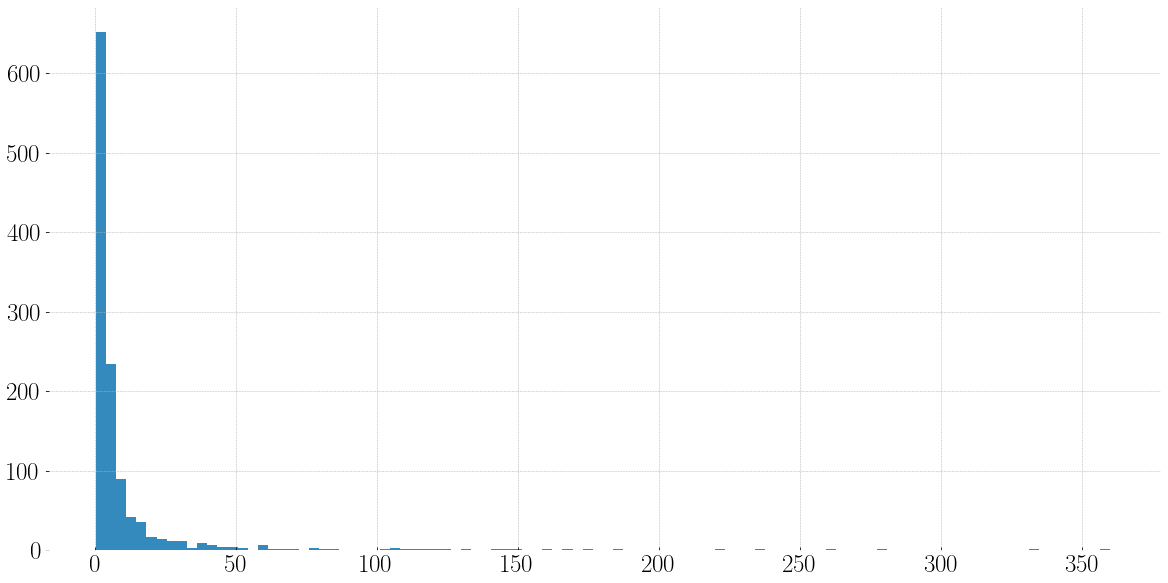

In [17]:
plt.hist(allb, bins=100)

How to decide on the bins for $b$? For now, I will try to arbitrarily choose based on the distribution.

In [18]:
test = {}
for i in range(4):
    test[i] = {}
    
for ego in blamb.keys():
    df = blamb[ego].loc[blamb[ego]['alpha'] == 1]
    for i in df.index:
        lamb = df.at[i, 'lambda']
        b = df.at[i, 'g']
        test[3][lamb] = test[3].get(lamb, 0) + 1
        if b < 17:
            test[0][lamb] = test[0].get(lamb, 0) + 1
        elif (b >= 17) and (b < 34):
            test[1][lamb] = test[1].get(lamb, 0) + 1
        else:
            test[2][lamb] = test[2].get(lamb, 0) + 1

for i in test.keys():
    test[i] = pd.DataFrame.from_dict(test[i], orient='index')
    test[i].sort_index(inplace=True)

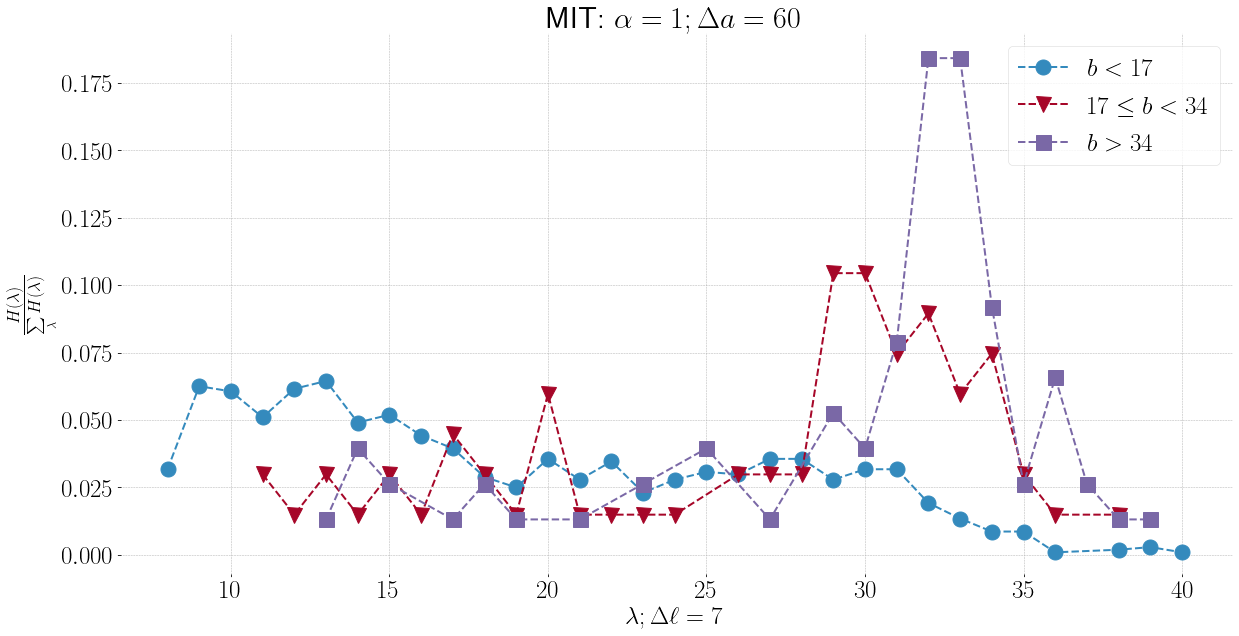

In [19]:
legends = [r"$b < 17$", r"$17 \leq b < 34$", r"$b > 34$", r"All $b$"]
plt.title(r"MIT: $\alpha = 1; \Delta a  = 60$")
plt.xlabel(r"$\lambda; \Delta \ell = 7$")
plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
for i in range(3):
    plt.plot(test[i].index, test[i][0] / sum(test[i][0]), marker=markers[i], linestyle="--", markersize=15, label=legends[i])
plt.legend()

But I could also choose bins in terms of the perrcentiles (33, 66, 100)

In [21]:
p33, p66 = np.percentile(allb, 33), np.percentile(allb, 66)
test = {}
for i in range(4):
    test[i] = {}
    
for ego in blamb.keys():
    df = blamb[ego].loc[blamb[ego]['alpha'] == 1]
    for i in df.index:
        lamb = df.at[i, 'lambda']
        b = df.at[i, 'g']
        test[3][lamb] = test[3].get(lamb, 0) + 1
        if b < p33:
            test[0][lamb] = test[0].get(lamb, 0) + 1
        elif (b >= p33) and (b < p66):
            test[1][lamb] = test[1].get(lamb, 0) + 1
        else:
            test[2][lamb] = test[2].get(lamb, 0) + 1

for i in test.keys():
    test[i] = pd.DataFrame.from_dict(test[i], orient='index')
    test[i].sort_index(inplace=True)

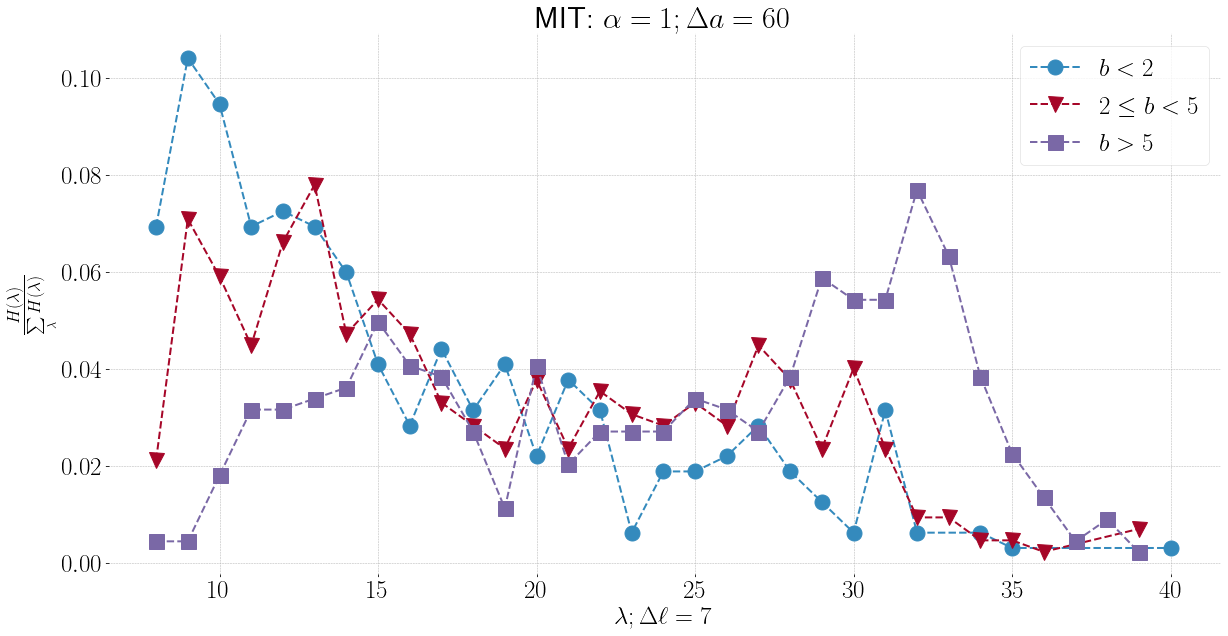

In [22]:
legends = [fr"$b < {int(p33)}$", fr"${int(p33)} \leq b < {int(p66)}$", fr"$b > {int(p66)}$", r"All $b$"]
plt.title(r"MIT: $\alpha = 1; \Delta a  = 60$")
plt.xlabel(r"$\lambda; \Delta \ell = 7$")
plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
for i in range(3):
    plt.plot(test[i].index, test[i][0] / sum(test[i][0]), marker=markers[i], linestyle="--", markersize=15, label=legends[i])
plt.legend()

# Distributions of lifetime separated by $F$

In [23]:
for ego in fall.keys():
    for alter in fall[ego].keys():
        df = fall[ego][alter]
        #print(list(df['lambda']))

In [24]:
allf = []
for ego in fall.keys():
    for alter in fall[ego].keys():
        df = fall[ego][alter].loc[fall[ego][alter]['alpha'] == 1]
        for i in df['lambda']:
            allf.append(i)
        
[max(allf), min(allf), len(allf)]

[40, 8, 1741]

In [25]:
p = [np.percentile(allf, q) for q in (33, 66)]
p

[14.0, 25.0]

(array([ 41.,   0.,   0., 114.,   0.,   0.,  95.,   0.,   0.,  78.,   0.,
          0., 109.,   0.,   0., 112.,   0.,   0.,  80.,   0.,   0.,  85.,
          0.,   0.,   0.,  72.,   0.,   0.,  60.,   0.,   0.,  40.,   0.,
          0.,  35.,   0.,   0.,  48.,   0.,   0.,  44.,   0.,   0.,  52.,
          0.,   0.,  37.,   0.,   0.,   0.,  43.,   0.,   0.,  49.,   0.,
          0.,  50.,   0.,   0.,  61.,   0.,   0.,  50.,   0.,   0.,  56.,
          0.,   0.,  57.,   0.,   0.,  60.,   0.,   0.,   0.,  73.,   0.,
          0.,  52.,   0.,   0.,  36.,   0.,   0.,  25.,   0.,   0.,  12.,
          0.,   0.,   4.,   0.,   0.,   4.,   0.,   0.,   6.,   0.,   0.,
          1.]),
 array([ 8.  ,  8.32,  8.64,  8.96,  9.28,  9.6 ,  9.92, 10.24, 10.56,
        10.88, 11.2 , 11.52, 11.84, 12.16, 12.48, 12.8 , 13.12, 13.44,
        13.76, 14.08, 14.4 , 14.72, 15.04, 15.36, 15.68, 16.  , 16.32,
        16.64, 16.96, 17.28, 17.6 , 17.92, 18.24, 18.56, 18.88, 19.2 ,
        19.52, 19.84, 20.16, 20.48

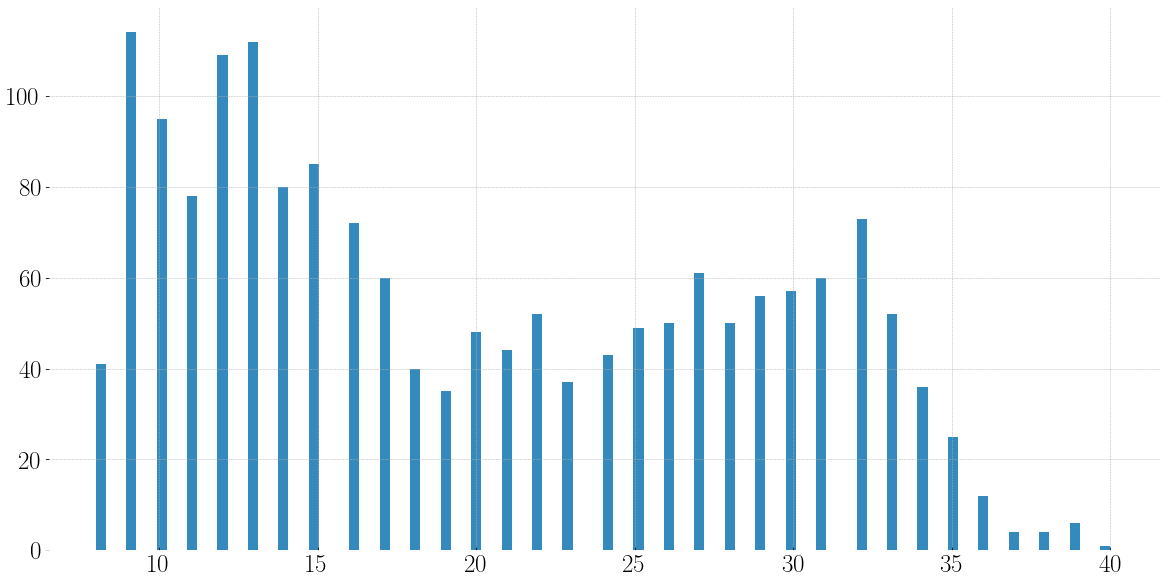

In [26]:
plt.hist(allf, bins=100)

In [27]:
test = {}
for i in range(4):
    test[i] = {}
    
for ego in fall.keys():
    for alter in fall[ego].keys():
        df = fall[ego][alter].loc[fall[ego][alter]['alpha'] == 1]
        if len(df) > 0:
            lamb = df.iloc[0]['lambda']
            test[3][lamb] = test[3].get(lamb, 0) + 1
            for f in df['f']:
                if f < p[0]:
                    test[0][lamb] = test[0].get(lamb, 0) + 1
                elif (f >= p[0]) and (f < p[1]):
                    test[1][lamb] = test[1].get(lamb, 0) + 1
                else:
                    test[2][lamb] = test[2].get(lamb, 0) + 1

for i in test.keys():
    test[i] = pd.DataFrame.from_dict(test[i], orient='index')
    test[i].sort_index(inplace=True)

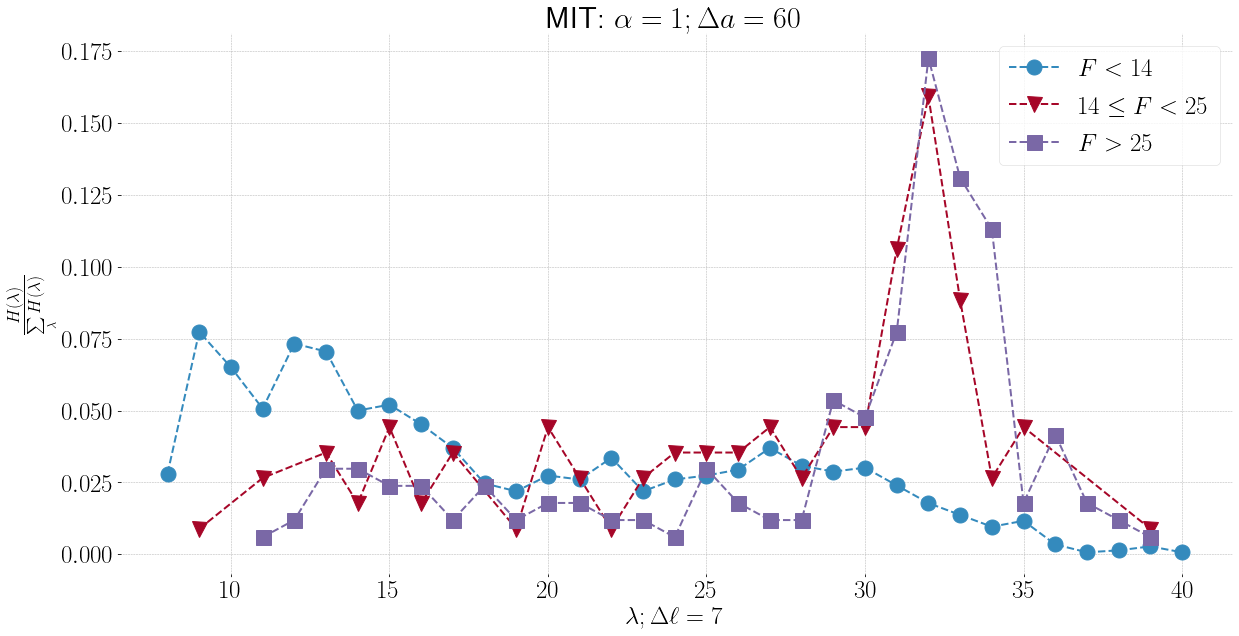

In [28]:
legends = [fr"$F < {int(p[0])}$", fr"${int(p[0])} \leq F < {int(p[1])}$", fr"$F > {int(p[1])}$", r"All $F$"]
plt.title(r"MIT: $\alpha = 1; \Delta a  = 60$")
plt.xlabel(r"$\lambda; \Delta \ell = 7$")
plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
for i in range(3):
    plt.plot(test[i].index, test[i][0] / sum(test[i][0]), marker=markers[i], linestyle="--", markersize=15, label=legends[i])
plt.legend()

# Fixing the maximum length of the relationship between alter and ego

For this analysis, I will take every pair of ego-alter and **limit** the stage of the relationship to be $0 \leq a \leq 365$ and calculate the above quantities

(array([2.4077e+04, 2.8500e+03, 2.2420e+03, 1.6450e+03, 1.8070e+03,
        1.4570e+03, 1.2890e+03, 9.3900e+02, 1.3480e+03, 1.5200e+03,
        1.2650e+03, 1.2900e+03, 1.5780e+03, 1.4350e+03, 9.2500e+02,
        1.1420e+03, 1.3650e+03, 1.2370e+03, 1.1670e+03, 1.2360e+03,
        1.2540e+03, 8.3200e+02, 1.2470e+03, 1.1540e+03, 1.1140e+03,
        1.0800e+03, 1.1920e+03, 9.6400e+02, 7.7800e+02, 1.0550e+03,
        9.3700e+02, 1.1630e+03, 1.0020e+03, 1.0020e+03, 1.0490e+03,
        6.1500e+02, 9.7400e+02, 8.8300e+02, 9.4400e+02, 9.6600e+02,
        9.3400e+02, 9.7800e+02, 7.0800e+02, 9.4400e+02, 9.9000e+02,
        9.7400e+02, 9.4300e+02, 8.4200e+02, 9.6300e+02, 6.0000e+02,
        9.9800e+02, 9.7200e+02, 8.1800e+02, 9.9300e+02, 8.5200e+02,
        8.1500e+02, 8.1900e+02, 4.9800e+02, 7.4400e+02, 6.8900e+02,
        7.7100e+02, 7.6700e+02, 6.8200e+02, 7.9900e+02, 5.2800e+02,
        8.9500e+02, 8.5500e+02, 7.1600e+02, 7.7000e+02, 6.6600e+02,
        8.3000e+02, 4.6000e+02, 7.0300e+02, 8.03

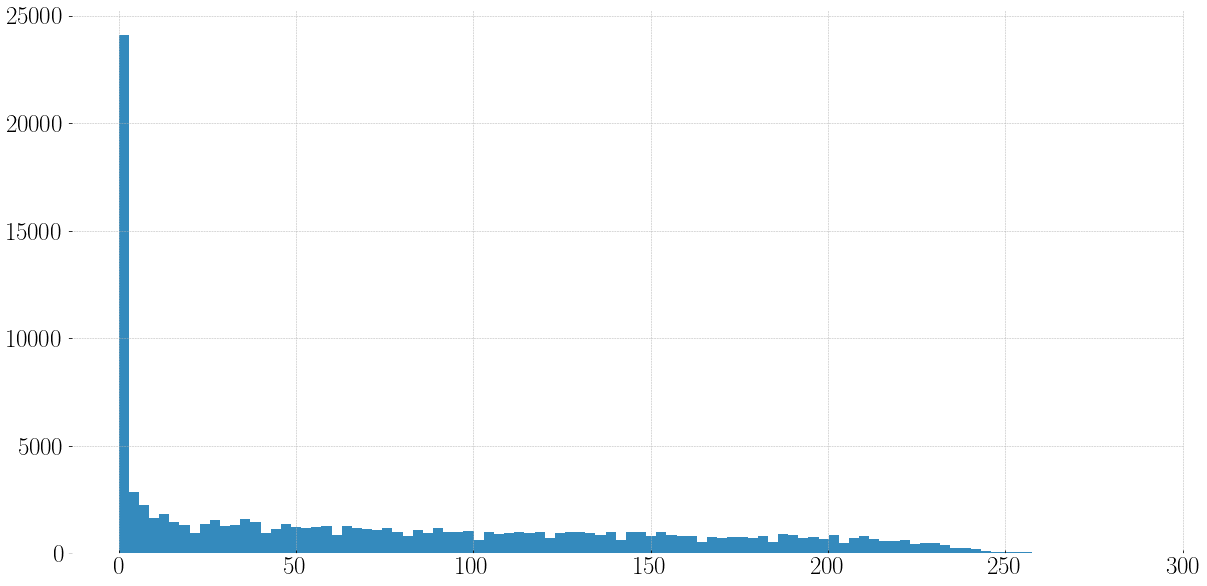

In [29]:
plt.hist(mit_calls['aclock'], bins = 100)

However, considering the histogram above, I will test this using the **entire** MIT dataset.

In [30]:
%time mit_calls = pc.allcalls('CallLog.csv', (), 'participantID.A', 'number.hash', ['local_time'], "%Y-%m-%d %H:%M:%S", header=True, min_activity=1)
mit_calls.head()
%time mit_pairs = pc.pairs(mit_calls)
%time mit_lives = pc.lives_dictionary(mit_calls)

CPU times: user 378 ms, sys: 20.1 ms, total: 398 ms
Wall time: 398 ms
CPU times: user 31.6 ms, sys: 0 ns, total: 31.6 ms
Wall time: 31.5 ms
CPU times: user 133 ms, sys: 0 ns, total: 133 ms
Wall time: 133 ms


(array([3.1169e+04, 5.1780e+03, 3.2400e+03, 3.8500e+03, 2.7340e+03,
        3.3830e+03, 3.2730e+03, 2.8430e+03, 3.4520e+03, 2.3710e+03,
        3.3380e+03, 2.4990e+03, 3.2240e+03, 3.1570e+03, 2.3420e+03,
        2.7010e+03, 2.3240e+03, 2.7020e+03, 2.6690e+03, 2.4240e+03,
        2.6810e+03, 2.1730e+03, 2.4960e+03, 1.7550e+03, 2.3880e+03,
        2.5160e+03, 2.1970e+03, 2.6500e+03, 2.0610e+03, 2.4040e+03,
        1.9960e+03, 2.4660e+03, 2.2840e+03, 1.8670e+03, 2.1670e+03,
        1.6120e+03, 2.0770e+03, 2.0080e+03, 1.7350e+03, 2.2300e+03,
        1.9250e+03, 2.5640e+03, 1.7370e+03, 2.0590e+03, 2.1740e+03,
        1.7240e+03, 2.0810e+03, 1.4390e+03, 1.8530e+03, 1.4190e+03,
        1.5580e+03, 1.1850e+03, 8.7300e+02, 9.5400e+02, 7.8900e+02,
        7.8100e+02, 6.6400e+02, 6.2100e+02, 6.5900e+02, 5.0500e+02,
        6.0400e+02, 5.8300e+02, 6.6500e+02, 6.1500e+02, 3.9100e+02,
        4.7700e+02, 2.7300e+02, 3.5700e+02, 2.1200e+02, 1.2200e+02,
        5.5000e+01, 2.0000e+01, 3.4000e+01, 3.80

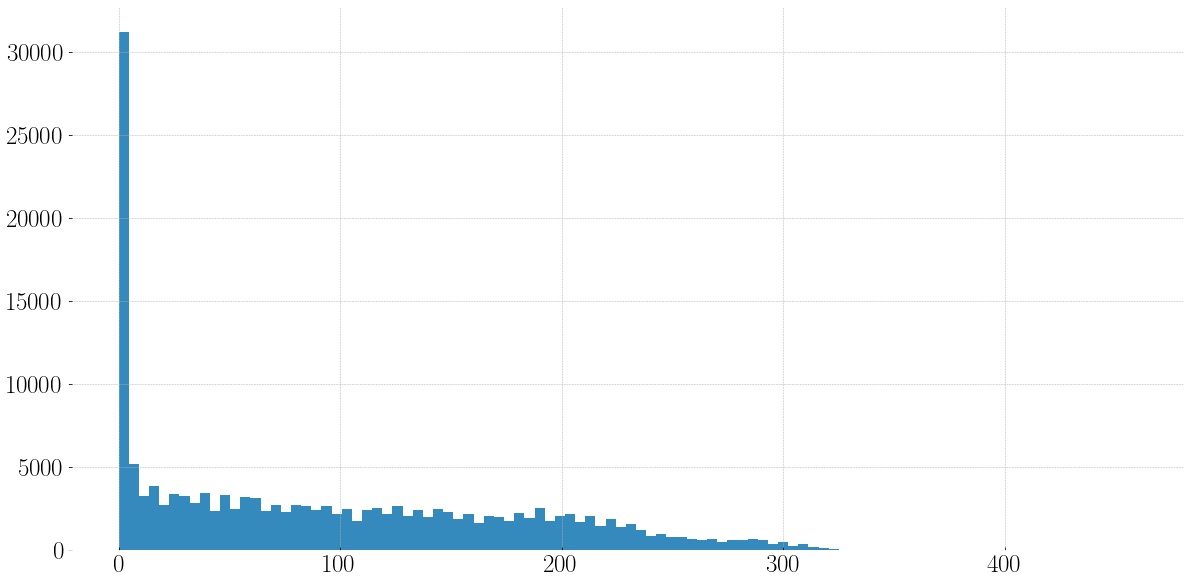

In [31]:
plt.hist(mit_calls['aclock'], bins = 100)

In [32]:
mit2 = mit_calls.loc[mit_calls['aclock'] <= 365]

In [33]:
[min(mit2['aclock']), max(mit2['aclock'])]

[0, 365]

In [54]:
%time dff = pc.get_f(mit2, 'all', 60, 7, mit_lives)

CPU times: user 21.5 s, sys: 17.8 ms, total: 21.5 s
Wall time: 21.5 s


In [55]:
allf = []
for ego in dff.keys():
    for alter in dff[ego].keys():
        df = dff[ego][alter].loc[dff[ego][alter]['alpha'] == 1]
        for i in df['lambda']:
            allf.append(i)
        
print([max(allf), min(allf), len(allf)])
p = [np.percentile(allf, q) for q in (33, 66)]
p

[65, 8, 2383]


[15.0, 28.0]

In [56]:
test = {}
for i in range(4):
    test[i] = {}
    
for ego in dff.keys():
    for alter in dff[ego].keys():
        df = dff[ego][alter].loc[dff[ego][alter]['alpha'] == 1]
        if len(df) > 0:
            lamb = df.iloc[0]['lambda']
            test[3][lamb] = test[3].get(lamb, 0) + 1
            for f in df['f']:
                if f < p[0]:
                    test[0][lamb] = test[0].get(lamb, 0) + 1
                elif (f >= p[0]) and (f < p[1]):
                    test[1][lamb] = test[1].get(lamb, 0) + 1
                else:
                    test[2][lamb] = test[2].get(lamb, 0) + 1

for i in test.keys():
    test[i] = pd.DataFrame.from_dict(test[i], orient='index')
    test[i].sort_index(inplace=True)

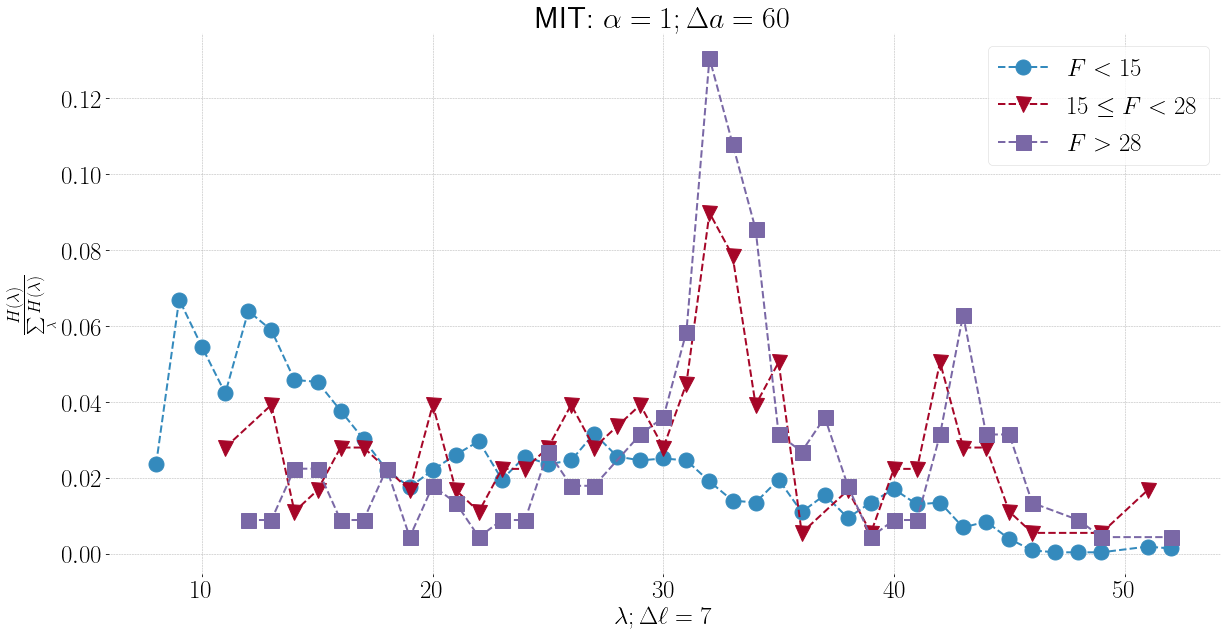

In [37]:
legends = [fr"$F < {int(p[0])}$", fr"${int(p[0])} \leq F < {int(p[1])}$", fr"$F > {int(p[1])}$", r"All $F$"]
plt.title(r"MIT: $\alpha = 1; \Delta a  = 60$")
plt.xlabel(r"$\lambda; \Delta \ell = 7$")
plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
for i in range(3):
    plt.plot(test[i].index, test[i][0] / sum(test[i][0]), marker=markers[i], linestyle="--", markersize=15, label=legends[i])
plt.legend()

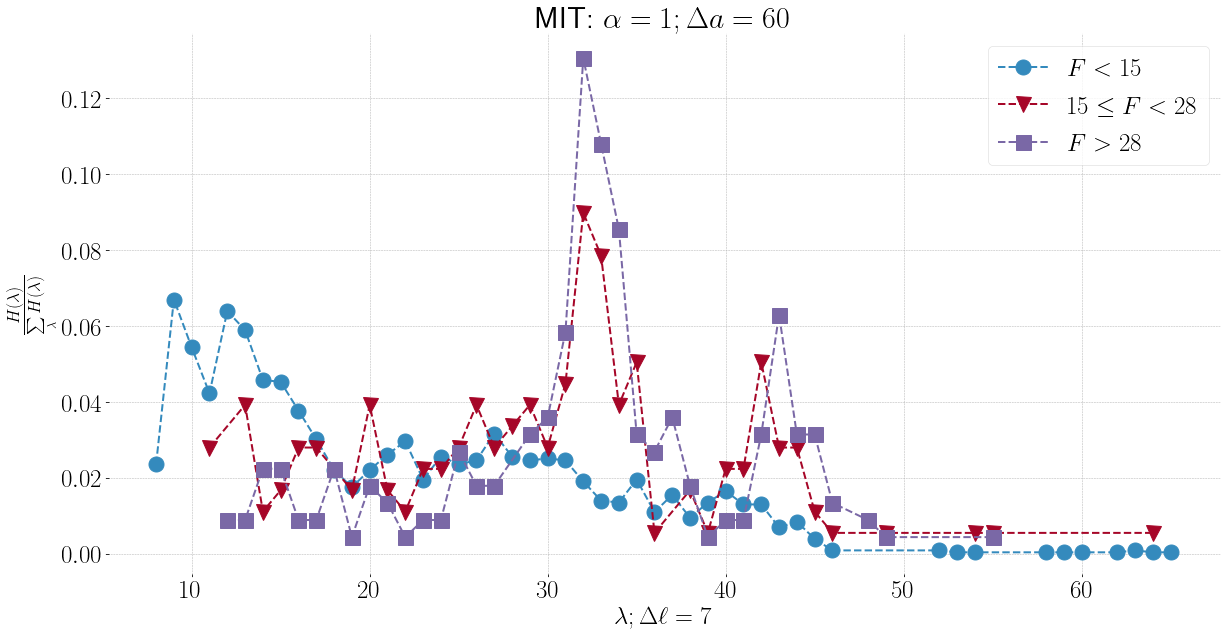

In [57]:
legends = [fr"$F < {int(p[0])}$", fr"${int(p[0])} \leq F < {int(p[1])}$", fr"$F > {int(p[1])}$", r"All $F$"]
plt.title(r"MIT: $\alpha = 1; \Delta a  = 60$")
plt.xlabel(r"$\lambda; \Delta \ell = 7$")
plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
for i in range(3):
    plt.plot(test[i].index, test[i][0] / sum(test[i][0]), marker=markers[i], linestyle="--", markersize=15, label=legends[i])
plt.legend()

# Limiting egos

Now we can limit all activity from egos after 1 month they first appeared in the data

(array([ 1.,  0.,  1.,  0.,  1., 24., 14.,  8., 36., 45.]),
 array([  0. ,  24.6,  49.2,  73.8,  98.4, 123. , 147.6, 172.2, 196.8,
        221.4, 246. ]),
 <BarContainer object of 10 artists>)

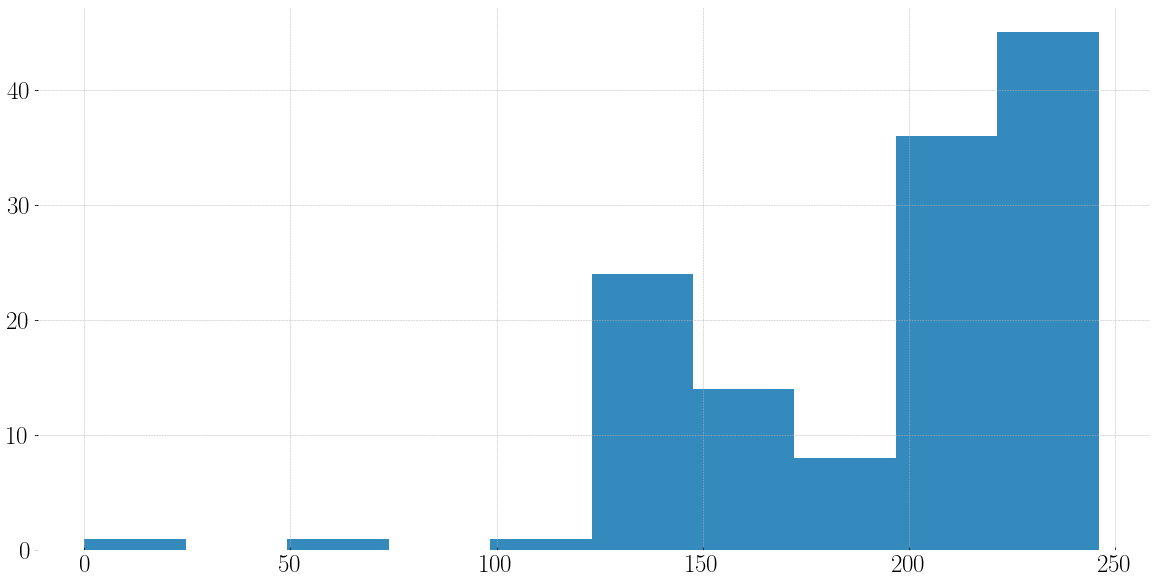

In [38]:
plt.hist(mit2.groupby('ego')[['uclock']].min()['uclock'])

In [39]:
tmp = mit2.groupby('ego')[['uclock']].min()

In [40]:
tmp.loc[egolist[0]]['uclock'] + 30

253

In [41]:
mit3 = pd.DataFrame()
for ego in mit2['ego'].unique():
    df = mit2.loc[mit2['ego'] == ego]
    minday = tmp.loc[ego]['uclock'] + 30
    df1 = df.loc[df['uclock'] >= minday]
    mit3 = mit3.append(df1).reset_index(drop=True)

(array([ 1.,  0.,  1.,  1.,  1., 31.,  3., 15., 68.,  4.]),
 array([ 31. ,  57.7,  84.4, 111.1, 137.8, 164.5, 191.2, 217.9, 244.6,
        271.3, 298. ]),
 <BarContainer object of 10 artists>)

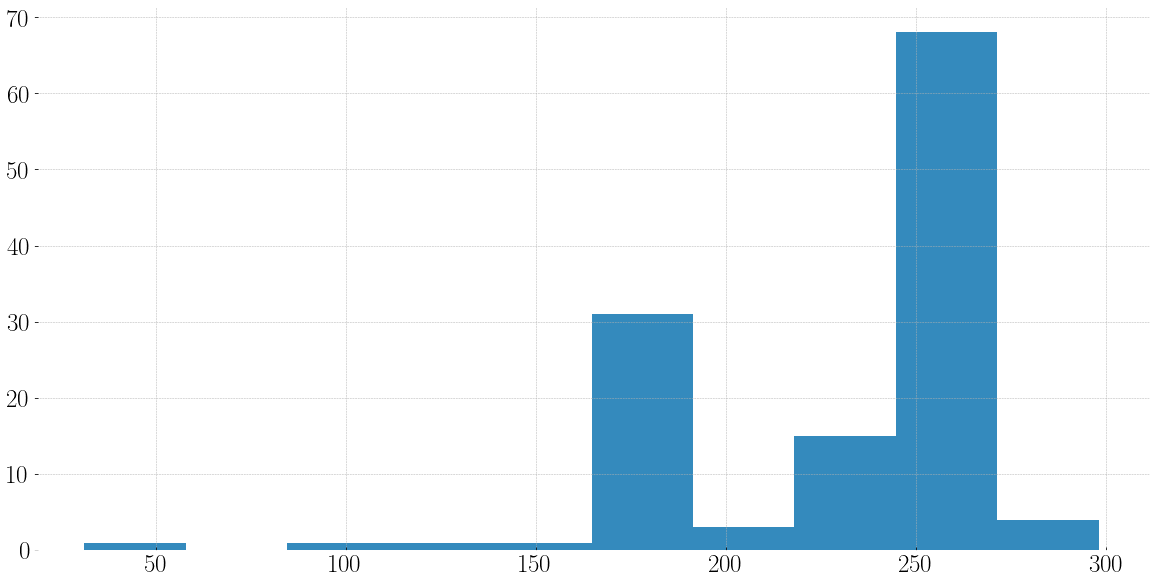

In [42]:
plt.hist(mit3.groupby('ego')[['uclock']].min()['uclock'])

Considering the histogram above, I will make all alters to have a relationship with ego of **at most** 6 months.

In [43]:
mit4 = mit3.loc[mit3['aclock'] <= 200]

In [51]:
%time dff = pc.get_f(mit4, 'all', 60, 7, mit_lives)
allf = []
for ego in dff.keys():
    for alter in dff[ego].keys():
        df = dff[ego][alter].loc[dff[ego][alter]['alpha'] == 1]
        for i in df['lambda']:
            allf.append(i)
        
print([max(allf), min(allf), len(allf)])
p = [np.percentile(allf, q) for q in (33, 66)]
p

CPU times: user 18.9 s, sys: 14.7 ms, total: 18.9 s
Wall time: 18.9 s
[65, 8, 2383]


[15.0, 28.0]

In [52]:
test = {}
for i in range(4):
    test[i] = {}
    
for ego in dff.keys():
    for alter in dff[ego].keys():
        df = dff[ego][alter].loc[dff[ego][alter]['alpha'] == 1]
        if len(df) > 0:
            lamb = df.iloc[0]['lambda']
            test[3][lamb] = test[3].get(lamb, 0) + 1
            for f in df['f']:
                if f < p[0]:
                    test[0][lamb] = test[0].get(lamb, 0) + 1
                elif (f >= p[0]) and (f < p[1]):
                    test[1][lamb] = test[1].get(lamb, 0) + 1
                else:
                    test[2][lamb] = test[2].get(lamb, 0) + 1

for i in test.keys():
    test[i] = pd.DataFrame.from_dict(test[i], orient='index')
    test[i].sort_index(inplace=True)

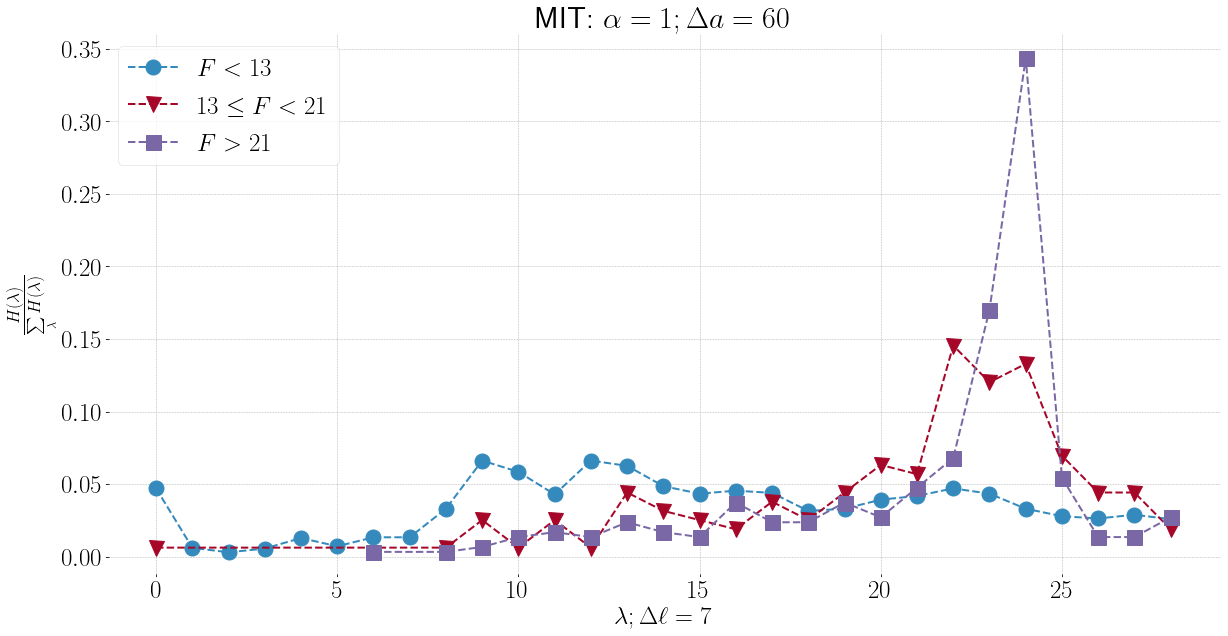

In [46]:
legends = [fr"$F < {int(p[0])}$", fr"${int(p[0])} \leq F < {int(p[1])}$", fr"$F > {int(p[1])}$", r"All $F$"]
plt.title(r"MIT: $\alpha = 1; \Delta a  = 60$")
plt.xlabel(r"$\lambda; \Delta \ell = 7$")
plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
for i in range(3):
    plt.plot(test[i].index, test[i][0] / sum(test[i][0]), marker=markers[i], linestyle="--", markersize=15, label=legends[i])
plt.legend()

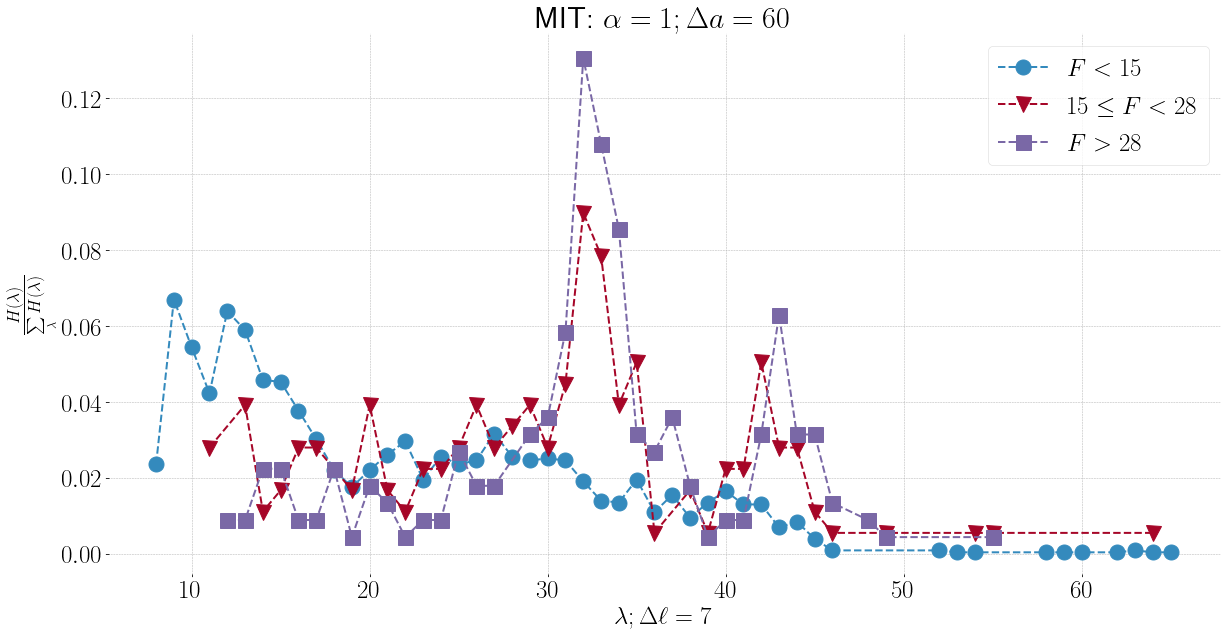

In [53]:
legends = [fr"$F < {int(p[0])}$", fr"${int(p[0])} \leq F < {int(p[1])}$", fr"$F > {int(p[1])}$", r"All $F$"]
plt.title(r"MIT: $\alpha = 1; \Delta a  = 60$")
plt.xlabel(r"$\lambda; \Delta \ell = 7$")
plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
for i in range(3):
    plt.plot(test[i].index, test[i][0] / sum(test[i][0]), marker=markers[i], linestyle="--", markersize=15, label=legends[i])
plt.legend()

## Using the same dataset as above, but now with $b$

The dataset used in the previous plot contains all calls starting 1 month after ego appeared; and all alters limited to $a \leq 200$

In [58]:
%time dfb = pc.get_b(dff, 'lambda')

CPU times: user 3.88 s, sys: 26.5 ms, total: 3.9 s
Wall time: 3.9 s


[360.0, 0.25, 1182]


(array([651., 234.,  89.,  42.,  36.,  17.,  14.,  11.,  12.,   3.,   9.,
          6.,   4.,   4.,   3.,   0.,   7.,   1.,   2.,   2.,   0.,   3.,
          2.,   2.,   0.,   0.,   0.,   0.,   1.,   3.,   1.,   2.,   1.,
          2.,   1.,   0.,   1.,   0.,   0.,   2.,   1.,   1.,   0.,   0.,
          1.,   0.,   2.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([2.500000e-01, 3.847500e+00, 7.445000e+00, 1.104250e+01,
        1.464000e+01, 1.823750e+01, 2.183500e+01, 2.543250e+01,
        2.903000e+01, 3.262750e+01, 3.622500e+01, 3.982250e+01,
        4.342000e+01, 4.701750e+01, 5.061500e+01, 5.421250e+01,
        5.781000e+01, 6.140750e+01, 6.500500e+01, 6.860250e+01

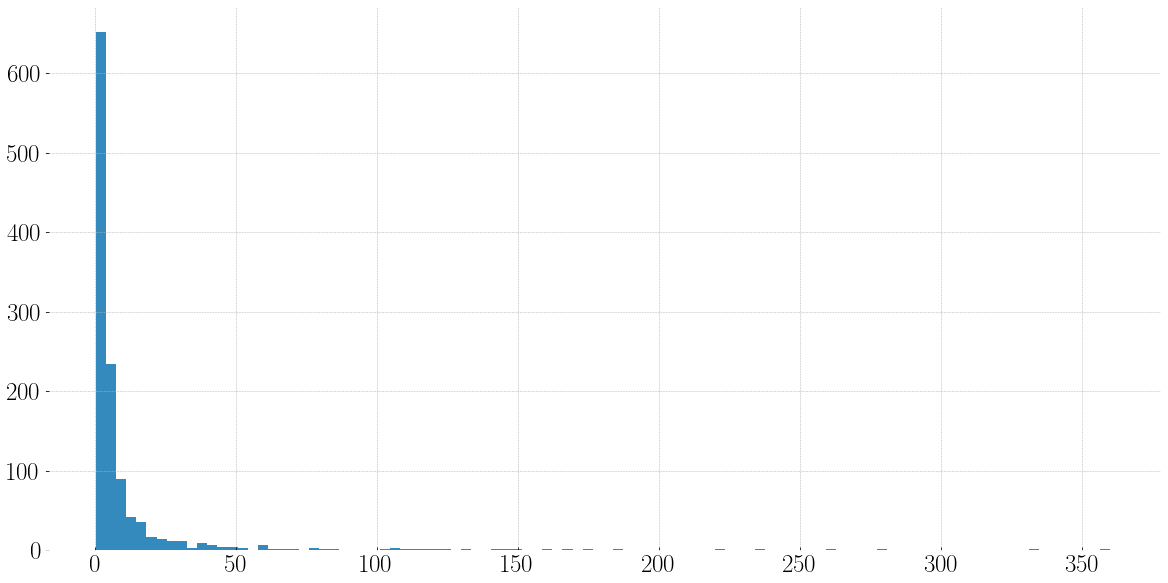

In [60]:
allb = []
for ego in blamb.keys():
    df = blamb[ego].loc[blamb[ego]['alpha'] == 1]
    for i in df.index:
        allb.append(df.at[i, 'g'])
        
print([max(allb), min(allb), len(allb)])
plt.hist(allb, bins=100)

In [61]:
p33, p66 = np.percentile(allb, 33), np.percentile(allb, 66)
test = {}
for i in range(4):
    test[i] = {}
    
for ego in blamb.keys():
    df = blamb[ego].loc[blamb[ego]['alpha'] == 1]
    for i in df.index:
        lamb = df.at[i, 'lambda']
        b = df.at[i, 'g']
        test[3][lamb] = test[3].get(lamb, 0) + 1
        if b < p33:
            test[0][lamb] = test[0].get(lamb, 0) + 1
        elif (b >= p33) and (b < p66):
            test[1][lamb] = test[1].get(lamb, 0) + 1
        else:
            test[2][lamb] = test[2].get(lamb, 0) + 1

for i in test.keys():
    test[i] = pd.DataFrame.from_dict(test[i], orient='index')
    test[i].sort_index(inplace=True)

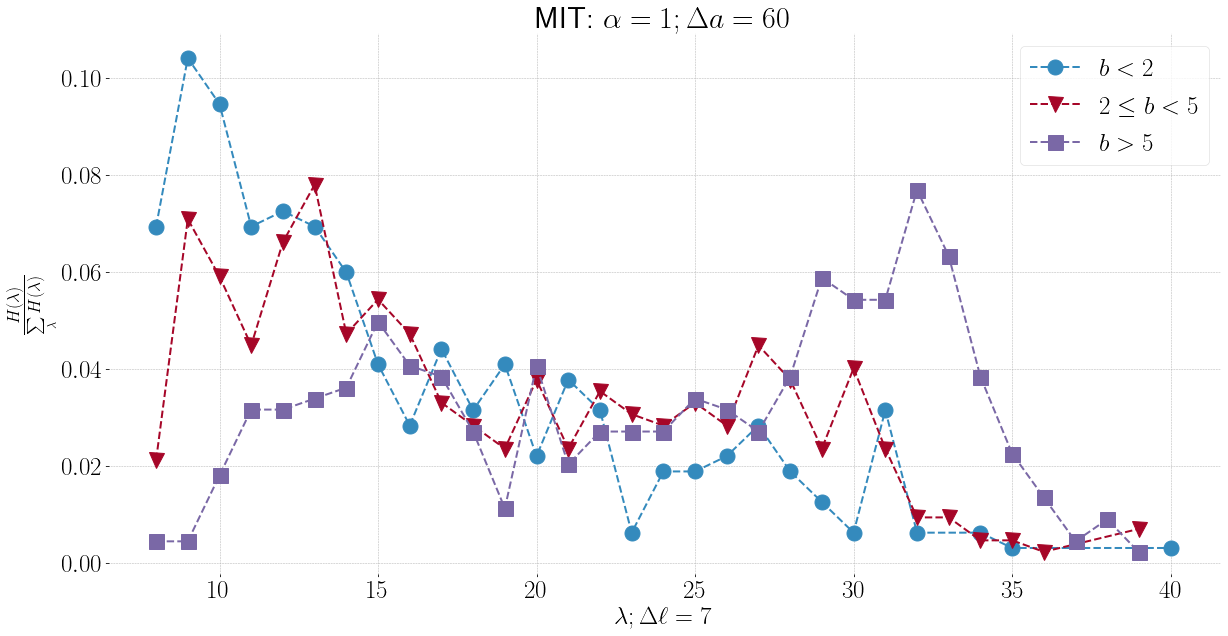

In [62]:
legends = [fr"$b < {int(p33)}$", fr"${int(p33)} \leq b < {int(p66)}$", fr"$b > {int(p66)}$", r"All $b$"]
plt.title(r"MIT: $\alpha = 1; \Delta a  = 60$")
plt.xlabel(r"$\lambda; \Delta \ell = 7$")
plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
for i in range(3):
    plt.plot(test[i].index, test[i][0] / sum(test[i][0]), marker=markers[i], linestyle="--", markersize=15, label=legends[i])
plt.legend()

# Testing functions

In [48]:
def get_f(callsdf, theego, lives_dict, bina, binell):
    '''
    This method outputs a dataframe with one row per (a, ell) combination, and the number
    of phone calls ego made to alters with that combination of parameters. The arguments are
    callsdf             : a dataframe produces with the "allcalls" or "remove_alters" methods
    theego              : specify an ego for results only using it. If the 'all' argument is
                        passed, it will calculate a dataframe per ego
    lives_dict          : dictionary produces with the "lives_dictionary" method
    bina                : the value for \Delta a
    binell              : \Delta ell
    '''
    if theego != 'all':
        df1 = callsdf.loc[callsdf['ego'] == theego]
    else:
        df1 = copy.deepcopy(callsdf)

    f = {}
    for ego in df1['ego'].unique():
        f[ego] = {}
        df2 = df1.loc[df1['ego'] == ego]
        for alter in df2['alter'].unique():
            f[ego][alter] = pd.DataFrame()
            df3 = df2.loc[df2['alter'] == alter]
            alla = set([i // bina for i in df3['aclock'].unique()])
            lamb = lives_dict[ego][alter]['ell'] // binell
            idx = 0
            for a in alla:
                f[ego][alter].at[idx, 'lamb'] = lamb
                f[ego][alter].at[idx, 'alpha'] = a
                idx += 1
            f[ego][alter]['f'] = 0
            for c in df3.index:
                a = df3.at[c, 'aclock']  // bina
                iidx = list(f[ego][alter].loc[f[ego][alter]['alpha'] == a].index)[0]
                f[ego][alter].at[iidx, 'f'] += 1

    return f

In [49]:
%time aaa = get_f(mit_calls, 'all', mit_lives, 60, 7)

KeyboardInterrupt: 

In [50]:
counter = 0
for ego in aaa.keys():
    for alter in aaa[ego].keys():
        df = aaa[ego][alter]
        print(list(df['lamb']))
        counter += 1
        if counter == 20:
            break
    if counter  == 20:
        break

NameError: name 'aaa' is not defined

In [ ]:
def get_f2(callsdf, theego, bina, binell):
    '''
    This method outputs a dataframe with one row per (a, ell) combination, and the number
    of phone calls ego made to alters with that combination of parameters. The arguments are

    callsdf             : a dataframe produces with the "allcalls" or "remove_alters" methods
    theego              : specify an ego for results only using it. If the 'all' argument is
                        passed, it will calculate a dataframe per ego
    lives_dict          : dictionary produces with the "lives_dictionary" method
    bina                : the value for \Delta a
    binell              : \Delta ell
    '''
    if theego != 'all':
        df1 = callsdf.loc[callsdf['ego'] == theego]
    else:
        df1 = callsdf.copy()

    f = {}
    for ego in df1['ego'].unique():
        f[ego] = {}
        df2 = df1.loc[df1['ego'] == ego]
        for alter in df2['alter'].unique():
            df3 = df2.loc[df2['alter'] == alter]
            df3.sort_values(by='time', inplace=True)
            lamb = (df3.iloc[-1]['uclock'] - df3.iloc[0]['uclock']) // binell
            df3['alpha'] = df3['aclock'] // bina
            tmp = df3.groupby('alpha').size()
            f[ego][alter] = pd.DataFrame({'lambda': lamb, 'alpha': tmp.index, 'f': tmp})
            f[ego][alter].reset_index(drop=True, inplace=True)
    return f

In [ ]:
%time bbb = get_f2(mit_calls, 'all', 60, 7)

In [ ]:
counter = 0
for ego in bbb.keys():
    for alter in bbb[ego].keys():
        df = bbb[ego][alter]
        print(list(df['lambda']))
        counter += 1
        if counter == 20:
            break
    if counter  == 20:
        break

In [ ]:
a = mit_calls.groupby(['ego', 'alter'])[['aclock']].min().rename(columns={'aclock': 't0'})
b = mit_calls.groupby(['ego', 'alter'])[['aclock']].max().rename(columns={'aclock': 'tf'})

In [ ]:
c = mit_calls.groupby(['ego', 'alter'])[['aclock']].count().rename(columns={'aclock': 'nij'})

In [ ]:
d = a.merge(b, left_index=True, right_index=True)
d = d.merge(c, left_index=True, right_index=True)

In [ ]:
d['ell'] = d['tf'] - d['t0']

In [ ]:
%time aaa = pc.lives_dictionary(mit_calls)

In [ ]:
%time bbb = ld(mit_calls)

In [ ]:
aaa[egolist[0]][alist[1]]

In [ ]:
bbb[egolist[0]][alist[1]]['ell']

In [ ]:
alist = list(fall[egolist[0]].keys())
fall[egolist[0]][alist[1]]

In [ ]:
aa = pd.DataFrame({1: ['a', 'a', 'b', 'c', 'c', 'c'], 2: 'hhhh', 3: list(range(6))})
aa

In [ ]:
bb = pd.DataFrame({1:['e', 'e', 'e', 'f', 'g', 'g', 'g'], 2: 'rock', 3:list(range(6, 13))})

In [ ]:
aa = aa.append(bb).reset_index(drop=True)
aa

In [ ]:
aa.groupby(1)